## Recognizing Digits using Machine Learning 

We are going to take following approach-
1. Problem Statement
2. Data 
3. Modelling
5. Evaluation
6. Experimentation

## 1. Problem Definition
In a statement
> Given dataset of tens of thousands of handwritten images, can we correctly identify digits.

## 2. Data
> *  The MNIST database was constructed from NIST's Special Database 3 and Special Database 1 which contain binary images of handwritten digits.
> * https://www.kaggle.com/competitions/digit-recognizer

## 3. Evaluation
> * If we can reach 95 percent accuracy at predicting what that digit is.
> * Our goal is to get **high accuracy**.
> * Accuracy is defined as **Number of correct predictions/ Total number of predictions.**


### Descriptions
My main goal as discussed is to identify digits and get high accuracy in this Kaggle Competition. Here I want to elaborate how I have planned to go about it.
>*  Our usual tendency is to seperate the dataset into train set and dev set (in case test set is already seperated), and train the whole   dataset and evaluate on dev set, but in this project I used **K-Fold cross-validation** extensively.
> * Cross-validation help us to get *clean* predictions, clean means the predictions that model has never seen before.
>* Second thing is to scale our dataset and to expirement if scalling of data helps to get better result.
>* I want to evaluate my dataset with different classification metrics such as *balanced-accuracy, micro-average, confusion matrix, ROC-AUC, Precision-Recall Curve* other than accuracy, reason being, evaluating binary classification data with these metrics is quiet straight-forward, lets see how can we evalute our Multi-class classification dataset using these metrics.
>* Another thing that I'm curious about is 'Data Augmentation', we'll se if data augmentation helps in getting better result.
>* I want to do hyperparameter tunning but not from GridSearchCV but from **Validation Curve**.
>* Then I'll plot **Learing curve** to get to know whether the training and cross-validation scores **converge** together.
>* Finally, save best model and evaluate on test set. 

In [1]:
#Preparing the tools

#Regular EDA and plotting libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl

#Model Evalution
from sklearn.model_selection import cross_validate,cross_val_score,train_test_split,cross_val_predict,GridSearchCV
from yellowbrick.model_selection import ValidationCurve,LearningCurve
from sklearn.metrics import confusion_matrix,precision_recall_curve,precision_recall_fscore_support,roc_curve, average_precision_score

#Model Preprocessing
from sklearn.preprocessing import StandardScaler,label_binarize

#Models frorm Scikit-Learn
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

#Image Processing
from scipy.ndimage.interpolation import shift

#Model Save
import pickle

### Load Data

In [2]:
#Importing data
data= pd.read_csv("../input/digit-recognizer/train.csv")
test_data =pd.read_csv("../input/digit-recognizer/test.csv")

### Data Exploration

In [3]:
data.shape

(42000, 785)

In [4]:
#Checking missing values
data.isna().sum().sum()

0

In [5]:
#Separting data into two parts
X = data.drop('label',axis=1)
y = data['label']

In [6]:
#Lets find out how many of each class are there (data imbalance)
y.value_counts(normalize=True)*100

1    11.152381
7    10.478571
3    10.359524
9     9.971429
2     9.945238
6     9.850000
0     9.838095
4     9.695238
8     9.673810
5     9.035714
Name: label, dtype: float64

In [7]:
# Reshaping random digit into 28*28 array
random_digit = X.iloc[21,:].values
random_digit_image = random_digit.reshape(28,28)

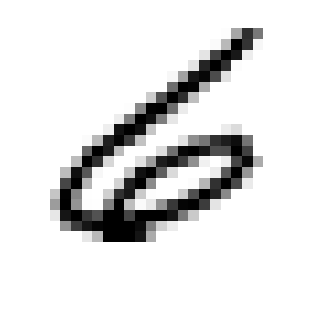

In [8]:
#Plotting random digit
plt.imshow(random_digit_image,cmap='binary')
plt.axis("off")
plt.show()

## 3. Modelling

In [10]:
#Creating objects(instances) of algorithims
sgd = SGDClassifier(max_iter=7000, random_state=101)
lg = LogisticRegression(multi_class='ovr',solver='saga',max_iter=2000,random_state=101)
rf = RandomForestClassifier(random_state=101)
ovr_rf = OneVsRestClassifier(rf)
ovr_sgd = OneVsRestClassifier(sgd)

In [11]:
#Splitting our data
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=101,stratify=y)

In [12]:
#Scalling of data
scaler = StandardScaler()

scaled_X_train= scaler.fit_transform(X_train.values)
scaled_X_val = scaler.transform(X_val.values)

### Lets build the machine learning model:
1. Random Forest Classifer
2. SGD Claasifier
3. Logistic Regression

**NOTE**:
*To get an idea of how different algorithims are doing on dataset, we will move forward with only 5000 examples as fititng the whole training set will take a lot of time.*

In [13]:
#Taking only 5000 examples
X_train_5000 = scaled_X_train[:5000]
y_train_5000 = y_train[:5000]

In [14]:
#Binarizing labels in  one-vs-all fashion
#It will be used later, in section where we have to plot roc-auc, precision-recall curves
y_train_5000_bnz = label_binarize(y_train_5000,classes=[0,1,2,3,4,5,6,7,8,9])
y_train_5000_bnz[0:5,:]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

In [15]:
#Lets start with RandomForestClassifier with average_precision
cross_validate(ovr_rf,X_train[:5000],y_train_5000_bnz,return_train_score=True,scoring='average_precision',)

{'fit_time': array([13.95930386, 14.15234542, 13.83090043, 14.0596118 , 13.99242353]),
 'score_time': array([0.26499057, 0.253932  , 0.25967598, 0.26232958, 0.26037693]),
 'test_score': array([0.95947697, 0.96555801, 0.96696724, 0.96664148, 0.97080927]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [16]:
cross_validate(rf,X_train_5000,y_train_5000,return_train_score=True,scoring='accuracy')

{'fit_time': array([2.11538267, 2.12575412, 2.09388161, 2.09738827, 2.09969997]),
 'score_time': array([0.05967116, 0.04759145, 0.04735756, 0.04724121, 0.04692936]),
 'test_score': array([0.931, 0.935, 0.943, 0.934, 0.94 ]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [17]:
cross_validate(rf,X_train_5000,y_train_5000,return_train_score=True,scoring='balanced_accuracy')

{'fit_time': array([1.86756873, 1.84600735, 1.81956935, 1.8553381 , 1.86401582]),
 'score_time': array([0.03307462, 0.0319562 , 0.03164792, 0.03226376, 0.03202391]),
 'test_score': array([0.93011268, 0.93354773, 0.94144407, 0.93221164, 0.93945702]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [18]:
cross_validate(ovr_sgd,X_train[:5000],y_train_5000_bnz,return_train_score=True,scoring='average_precision')

{'fit_time': array([2.36954641, 2.72613454, 2.44044805, 2.81119585, 2.50374269]),
 'score_time': array([0.11923862, 0.10434675, 0.10281467, 0.10174441, 0.09910321]),
 'test_score': array([0.87670048, 0.88356487, 0.86773819, 0.87858639, 0.88091733]),
 'train_score': array([0.98198346, 0.98144054, 0.98291086, 0.98197419, 0.9823829 ])}

In [19]:
cross_validate(sgd,X_train[:5000],y_train[:5000],return_train_score=True,scoring='accuracy')

{'fit_time': array([2.38914227, 2.26361609, 2.35724235, 2.3215971 , 2.48512435]),
 'score_time': array([0.00957847, 0.01000834, 0.01178145, 0.00983572, 0.00994468]),
 'test_score': array([0.85 , 0.856, 0.861, 0.853, 0.88 ]),
 'train_score': array([0.96275, 0.9635 , 0.9685 , 0.9595 , 0.97625])}

Points to be noted -
1.  RandomForestClassifier is giving good results but there seems to be some overfitting as train_score is around 1 and test_score is around 0.93'.
2. We are getting almost identical results with scoring as 'balanced accuracy' and simple 'accuracy', if there was class imblance,balanced accuracy would have given us different results, I have demostrated 'average_precision' also, but it usefull in case of class imbalance.
3. RandomForestClassifier is giving us better score than SGDClassifier,as SGDClassifier giving score less than 0.9 and above all it is overfitting more than RandomForestClassifier. 

## 4. Evalutation

In [20]:
#Predicting using Cross validation
y_pred_sgd = cross_val_predict(sgd,X_train_5000,y_train_5000,cv=5)
y_pred_rf = cross_val_predict(rf,X_train_5000,y_train_5000,cv=5)

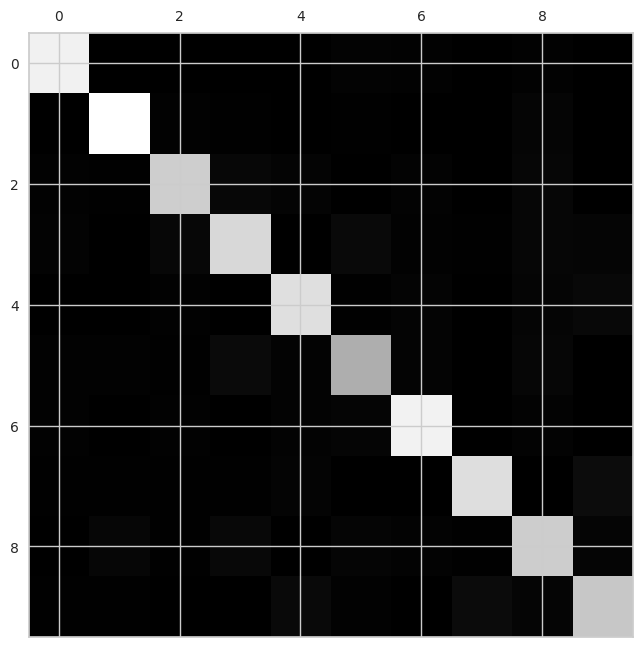

In [21]:
#SGDClassifier Confusion matrix 
#It is more convenient to look at image representation of confusion_matrix rather than lots of numbers.
fig, ax = plt.subplots(figsize=(12,8),dpi=100)

conf_mx_sgd = confusion_matrix(y_train_5000,y_pred_sgd)
ax.matshow(conf_mx_sgd,cmap=plt.cm.gray);

** Analysis** 
* Most of the diagonal blocks are bright which means they got correctly classifed, other than 2,5,9.

###  Lets plot error matrix to get a better idea.

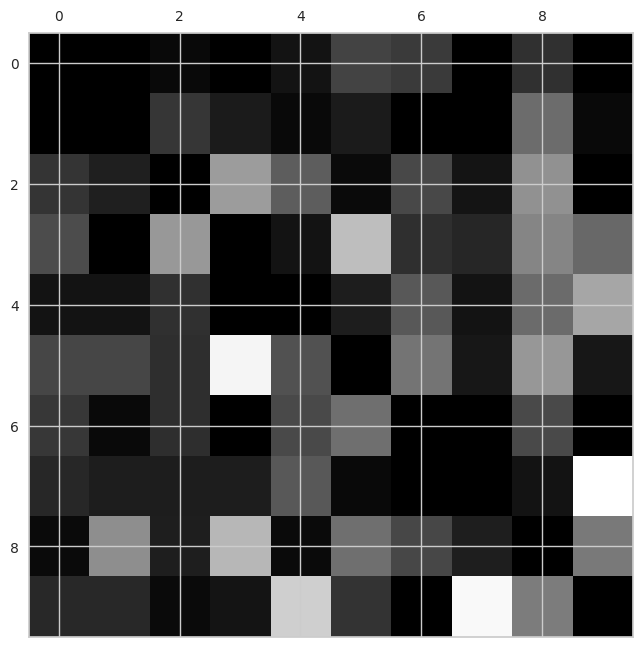

In [23]:
#Filling the diagonal with zero to keep only the errors
fig, ax = plt.subplots(figsize=(12,8),dpi=100)

row_sums  =conf_mx_sgd.sum(axis=1,keepdims=True)
norm_conf_mx_sgd = conf_mx_sgd/row_sums

np.fill_diagonal(norm_conf_mx_sgd,0)
ax.matshow(norm_conf_mx_sgd,cmap=plt.cm.gray);

**NOTE**
* Rows represent actual classes, while column represents predicted classes.
* The columns for 5,8 are quiet bright which means other digits got missclassified as 5 or 8.
* The row of 8 is also bright which means 8 is not properly classified.

### Lets do same process for RandomForestClassfier

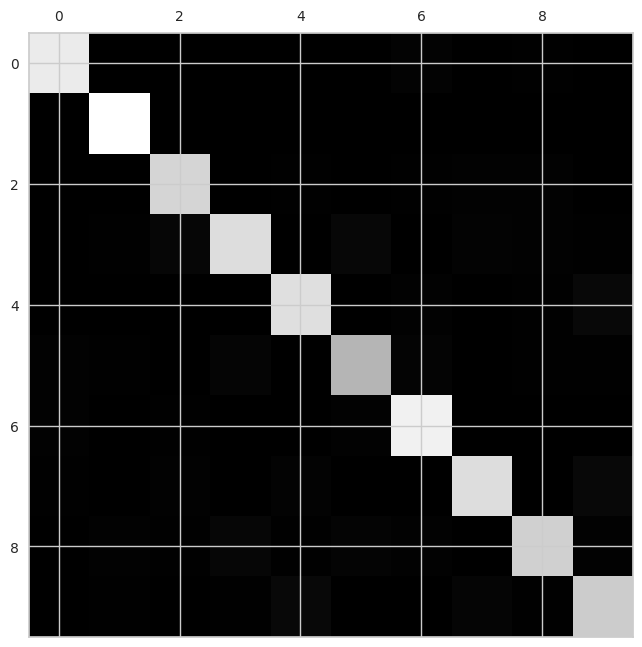

In [24]:
fig, ax = plt.subplots(figsize=(12,8),dpi=100)

conf_mx_rf = confusion_matrix(y_train_5000,y_pred_rf)
ax.matshow(conf_mx_rf,cmap=plt.cm.gray);

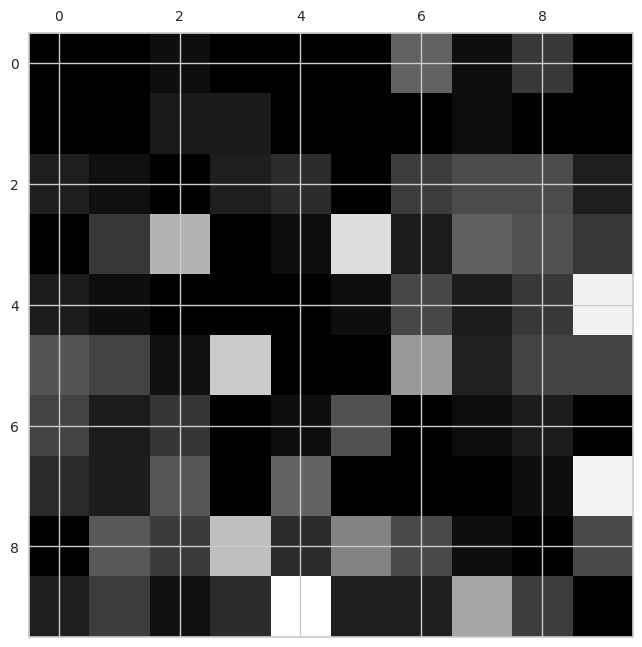

In [25]:
fig, ax = plt.subplots(figsize=(12,8),dpi=100)

row_sums  =conf_mx_rf.sum(axis=1,keepdims=True)
norm_conf_mx_rf = conf_mx_rf/row_sums

np.fill_diagonal(norm_conf_mx_rf,0)
ax.matshow(norm_conf_mx_rf,cmap=plt.cm.gray);

* It seems like RandomForestClassfier classifies 8 slightly better than SGDClassifier, also column of 8 is darker.

### It's time to more forward to calculate precision, recall and f1-score.
* Lets calculate these metrics with the help of 'micro-average'.
* **Micro-average** takes *one-vs-rest* approach, it gives aggregated results without focusing on particular class, so it can be more accurate in class imbalance.

In [26]:
y_proba_sgd = cross_val_predict(sgd,X_train_5000,y_train_5000,cv=5,method='decision_function')
y_proba_rf = cross_val_predict(rf,X_train_5000,y_train_5000,cv=5,method = 'predict_proba')

In [27]:
#Number of classes
sgd.fit(X_train_5000,y_train_5000)
sgd.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [28]:
#Precision_recall_fscore_support of RandomForestCLassifier
p, r, f, s = precision_recall_fscore_support(
    y_train_5000, y_pred_rf, labels=[0,1,2,3,4,5,6,7,8,9], average='micro',
)

print('Precision: ', p)
print('Recall: ', r)
print('f score: ', f)
print('Support: ', s)
print()

Precision:  0.9366
Recall:  0.9366
f score:  0.9366
Support:  None



In [29]:
#Precision_recall_fscore_support of SGDClassifier
p, r, f, s = precision_recall_fscore_support(
    y_train_5000, y_pred_sgd, labels=[0,1,2,3,4,5,6,7,8,9], average='micro',
)

print('Precision: ', p)
print('Recall: ', r)
print('f score: ', f)
print('Support: ', s)
print()

Precision:  0.8924
Recall:  0.8924
f score:  0.8924
Support:  None



**Analysis**
* RandomForestClassifier giving better scores than SGDClassifier.

### Let's plot Precision-Recall-Curve and ROC-AUC-Curve.

**NOTE** 
* For plotting these curves we need to get one-vs-rest predicitons

In [32]:
#Predictions for binarized output
ovr_pred_rf= cross_val_predict(ovr_rf, X_train_5000,y_train_5000_bnz)
ovr_pred_sgd= cross_val_predict(ovr_sgd, X_train_5000,y_train_5000_bnz)

In [33]:
def p_r_multi_plots(scores):
    #dictionary for precision and recall scores for each class
    pre = dict()
    rec = dict()
    
    #for every class
    for i in range(10):
        #calculating precision and recall score for each class
        pre[i],rec[i],_ = precision_recall_curve(y_train_5000_bnz[:,i],scores[:,i])
    return pre,rec

precision_ovr_sgd, recall_ovr_sgd = p_r_multi_plots(ovr_pred_sgd)
precision_ovr_rf, recall_ovr_rf = p_r_multi_plots(ovr_pred_rf)

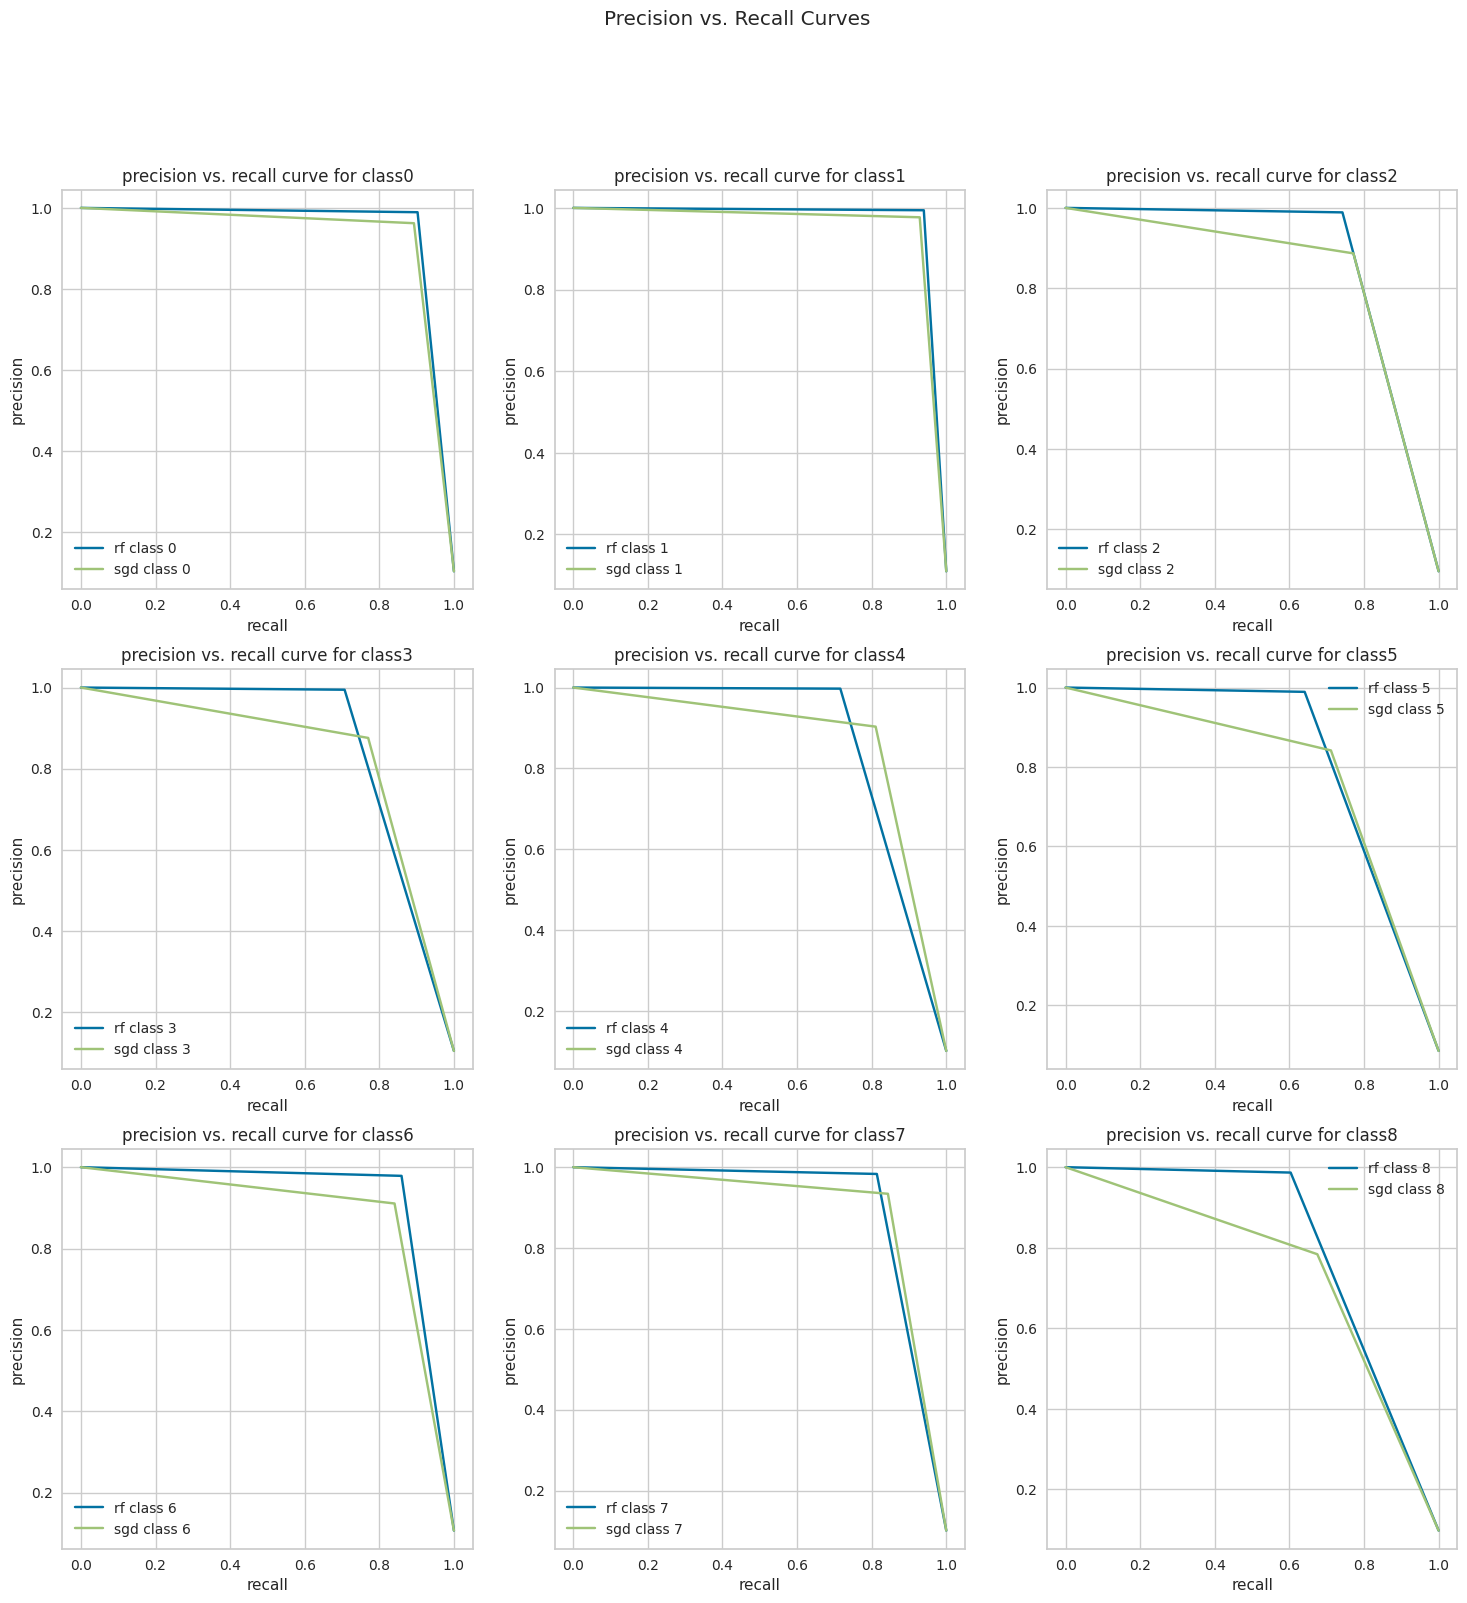

In [34]:
#Plotting subplots
fig,axes = plt.subplots(3,3,figsize=(18,18),dpi=100)
plt.suptitle("Precision vs. Recall Curves")
for i,ax in zip(range(10),axes.ravel()):
       
    ax.plot(recall_ovr_rf[i], precision_ovr_rf[i], label='rf class {}'.format(i))
    ax.plot(recall_ovr_sgd[i], precision_ovr_sgd[i], label='sgd class {}'.format(i))

    ax.legend()
    ax.set_xlabel("recall")
    ax.set_ylabel("precision")
    ax.set_title("precision vs. recall curve for class{}".format(i))

In [36]:
# for sgd
# .ravel() is used to get all classes in 1-D vector

precision_ovr_sgd["micro"], recall_ovr_sgd["micro"], _ = precision_recall_curve(
    y_train_5000_bnz.ravel(), ovr_pred_sgd.ravel(),
)

# for rfc
precision_ovr_rf["micro"], recall_ovr_rf["micro"], _ = precision_recall_curve(
    y_train_5000_bnz.ravel(), ovr_pred_rf.ravel(),
)

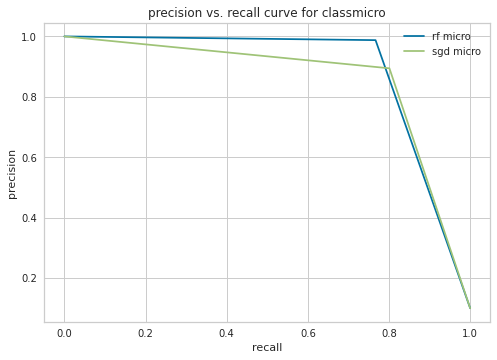

In [37]:
i = "micro"

plt.plot(recall_ovr_rf[i], precision_ovr_rf[i], label='rf micro')
plt.plot(recall_ovr_sgd[i], precision_ovr_sgd[i], label='sgd micro')

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve for class{}".format(i))
plt.show()

In [38]:
#Average precision for RandoForestClassifier
average_precision_score(y_train_5000_bnz,ovr_pred_rf)

0.7756725006369976

In [40]:
#Average precision for SGDClassifier
average_precision_score(y_train_5000_bnz,ovr_pred_sgd)

0.7340356980332555

**Analysis**
* As we can see class-wise Precision-Recall Curves, individual curve and average_precision_score for both classifiers, RFC is performing better in terms of **area coverage in plots** and **scoring high in terms of average_precision_score**.

### ROC-AUC Curve

In [41]:
def roc_auc_multi_plots(scores):
    #Dictionary for False Positive rate and True positive rate
    fpr = dict()
    tpr = {}
    
    #for each class
    for i in range(10):
        
        #calculating fpr,tpr for each class
        fpr[i], tpr[i], _ = roc_curve(
        y_train_5000_bnz[:,i], scores[:,i])
    return fpr,tpr    

fpr_rf, tpr_rf = roc_auc_multi_plots(ovr_pred_rf)
fpr_sgd, tpr_sgd = roc_auc_multi_plots(ovr_pred_sgd)

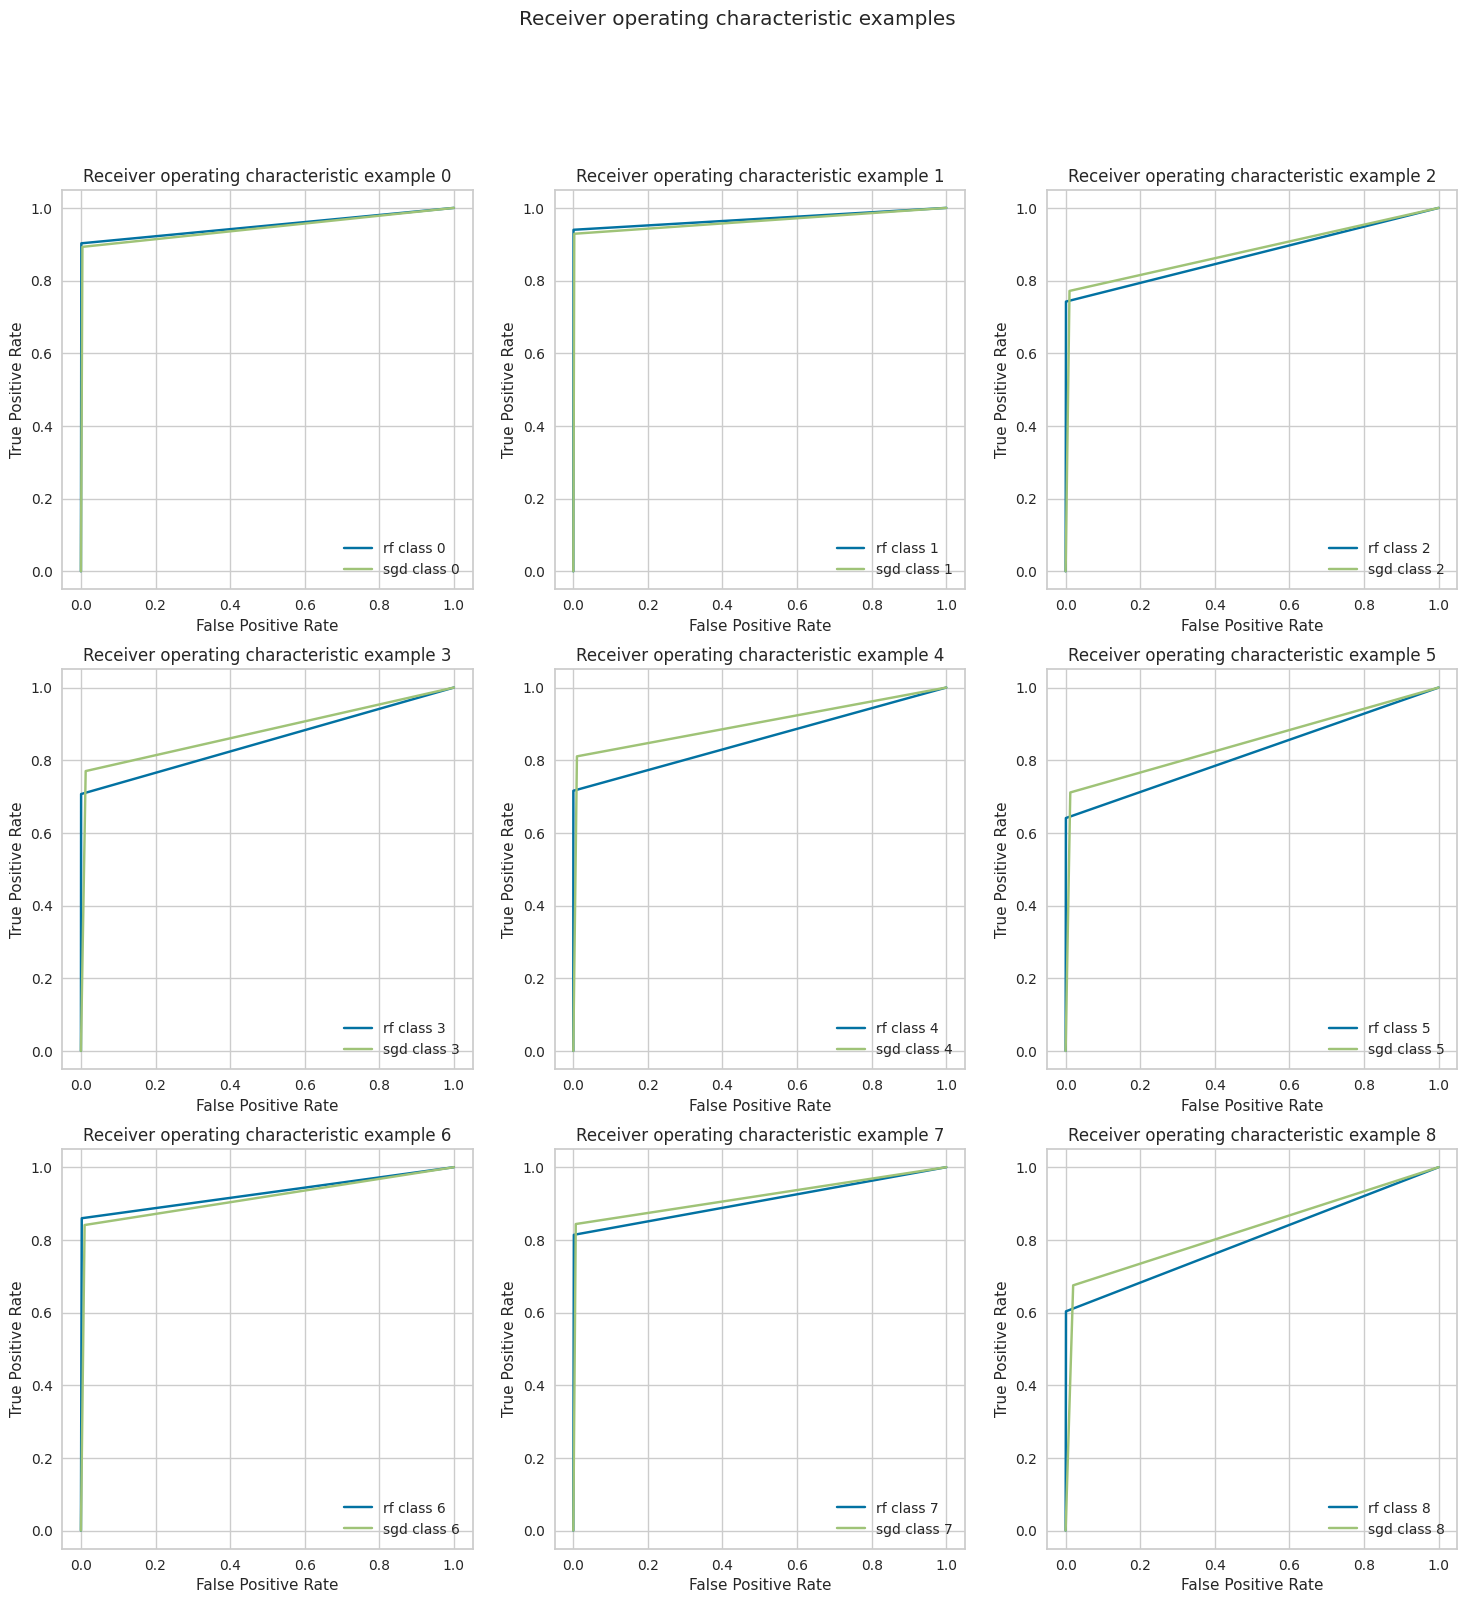

In [42]:
fig,axes = plt.subplots(3,3,figsize=(18,18),dpi=100)
plt.suptitle("Receiver operating characteristic examples")
for i,ax in zip(range(10),axes.ravel()):
    
    
    ax.plot(fpr_rf[i], tpr_rf[i], label='rf class {}'.format(i))
    ax.plot(fpr_sgd[i], tpr_sgd[i], label='sgd class {}'.format(i))
   
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example {}'.format(i))
    ax.legend(loc="lower right")

In [43]:
# aggregated fpr,tpr scores
fpr_rf["micro"], tpr_rf["micro"], _ = roc_curve(
    y_train_5000_bnz.ravel(), ovr_proba_rf.ravel(),
)


fpr_sgd["micro"], tpr_sgd["micro"], _ = roc_curve(
    y_train_5000_bnz.ravel(), ovr_proba_sgd.ravel(),
)

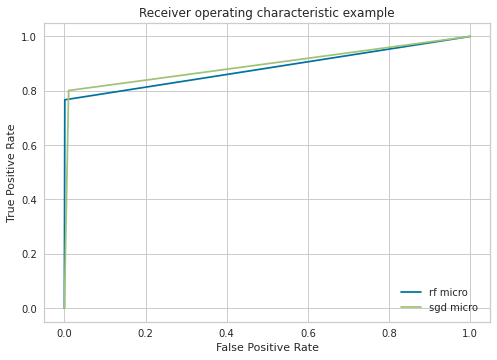

In [44]:
i = "micro"

plt.plot(fpr_rf[i], tpr_rf[i], label='rf micro ')
plt.plot(fpr_sgd[i], tpr_sgd[i], label='sgd micro ')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

**Analysis**
* One first look it seems like SGDCLassifier is performing better.

**NOTE**
> Precision-recall curves are recommended for skewed domain where ROC curves provides optimistic view of the performance.By looking at above graph, it is hard to analyze which classifier is doing better, but by looking at P-R Curve, RFC seems like a clear winner as it is covering more area with high margin.

## Data augmentation

In [46]:
#Function to shift image and reshape it 
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

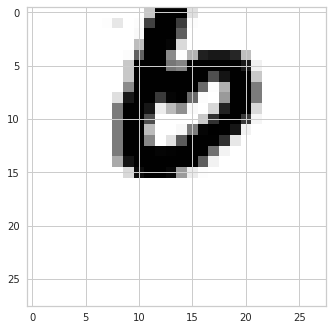

In [48]:
#Shifitng one image up
image = X_train.iloc[32594,:].values
shifted_image_down = shift_image(image, 0,-7)


plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys");

In [49]:
X_train_augmented = [image for image in X_train.values]
y_train_augmented = [label for label in y_train]

#each tuple represent shifiting image to left(-1,0) ,right(1,0), up(0,-1) and down(0,1)
for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):    
         for image, label in zip(X_train.values, y_train):
            
                #shifting every image left,right,up and down and adding in X_train_augmented
                X_train_augmented.append(shift_image(image, dx, dy)) 
                y_train_augmented.append(label)

#Converting list to array
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [50]:
#Shuffling our data
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [51]:
#Scaling our data
scaled_X_train_aug=scaler.fit_transform(X_train_augmented)
scaled_X_val = scaler.transform(X_val.values)

In [52]:
#Making predicitons on augmented data
y_pred_aug_rf = cross_val_predict(rf,scaled_X_train_aug[:5000],y_train_augmented[:5000],cv=5)

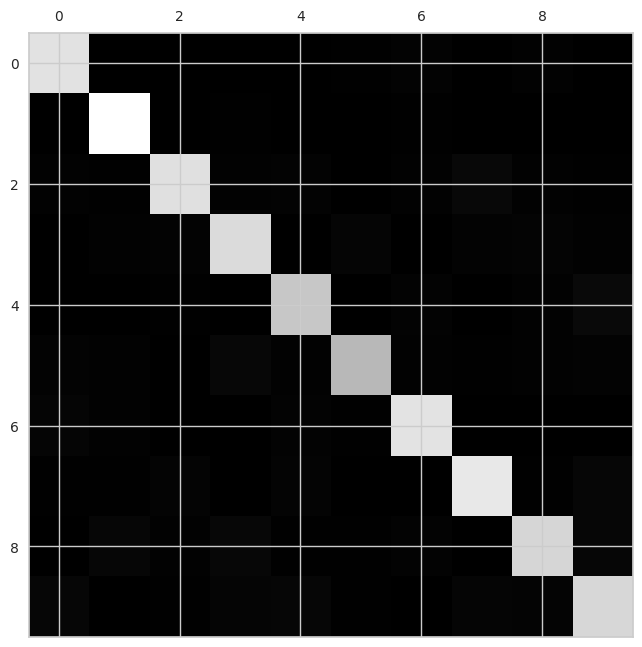

In [110]:
#Again plotting confusion matrix
fig, ax = plt.subplots(figsize=(12,8),dpi=100)

conf_mx_rf = confusion_matrix(y_train_augmented[:5000],y_pred_aug_rf)
ax.matshow(conf_mx_rf,cmap=plt.cm.gray);

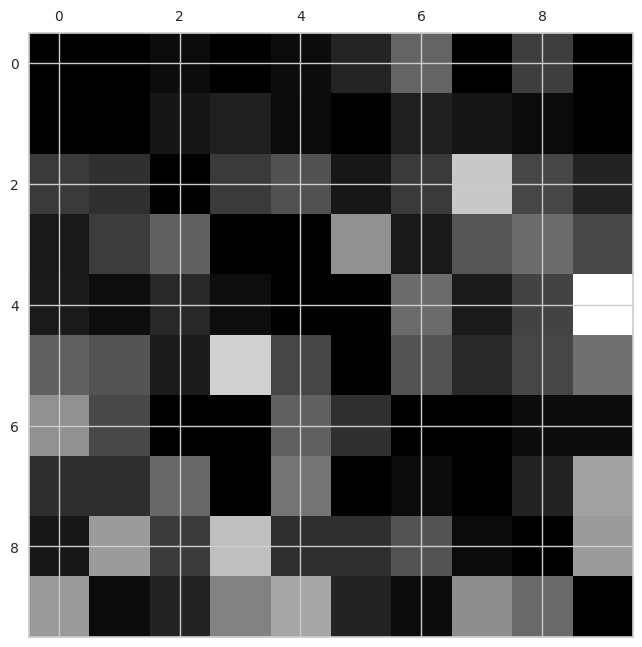

In [55]:
#Again plotting error matrix
fig, ax = plt.subplots(figsize=(12,8),dpi=100)

row_sums  =conf_mx_rf.sum(axis=1,keepdims=True)
norm_conf_mx_rf = conf_mx_rf/row_sums

np.fill_diagonal(norm_conf_mx_rf,0)
ax.matshow(norm_conf_mx_rf,cmap=plt.cm.gray);

The above error matrix seems similar to older one, so it seems like we should move forward with our final evaluation to get better insights.

## Hyperparamater tunning

In [56]:
# Dictionary for hyperparameters
grid = {'n_estimators':[100,200,500,1000],
       'max_depth':[1,2,4,8]}

In [57]:
grd_rf = GridSearchCV(rf,grid,cv=4,return_train_score=True)
grd_rf.fit(X_train_augmented[:5000],y_train_augmented[:5000])

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=101),
             param_grid={'max_depth': [1, 2, 4, 8],
                         'n_estimators': [100, 200, 500, 1000]},
             return_train_score=True)

In [58]:
#Creating dataframe for GridSearchCV results
results = pd.DataFrame(grd_rf.cv_results_)
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results[[
    'param_max_depth', 'param_n_estimators',
    'mean_test_score','mean_train_score',
]].head()

,param_max_depth,param_n_estimators,mean_test_score,mean_train_score
0,8,500,0.8838,0.967933
1,8,1000,0.8836,0.967667
2,8,200,0.8788,0.966467
3,8,100,0.8774,0.964600
4,4,1000,0.7560,0.783933


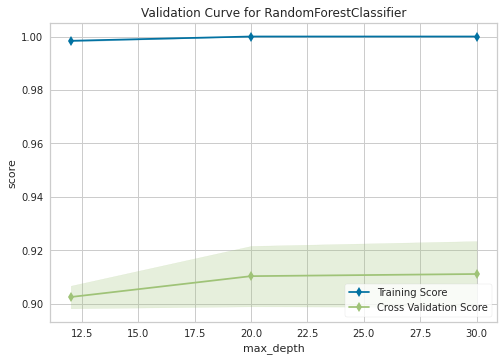

In [59]:
#max_depth hyper-paramater optimization using Validation curve
viz = ValidationCurve(rf, param_name="max_depth",
    param_range=[12,20,30], cv=5, scoring="accuracy"
)

viz.fit(X_train_augmented[:5000],y_train_augmented[:5000])
viz.show();

**NOTE** 
> As I got best test_score at max_depth = 8, I initially gave param_range- [6,8,10] for max_depth to get an idea if cross-validation score is increasing above max_depth=8 or not, so I changed param_range accrodingly as I was getting better result above max_depth=8.

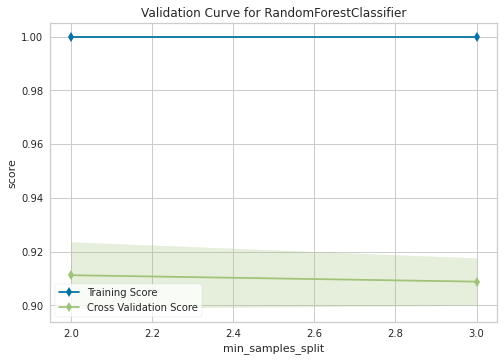

In [60]:
viz = ValidationCurve(rf, param_name="min_samples_split",
    param_range=[1, 2, 3], cv=5, scoring="accuracy"
)

viz.fit(X_train_augmented[:5000],y_train_augmented[:5000]);
viz.show();

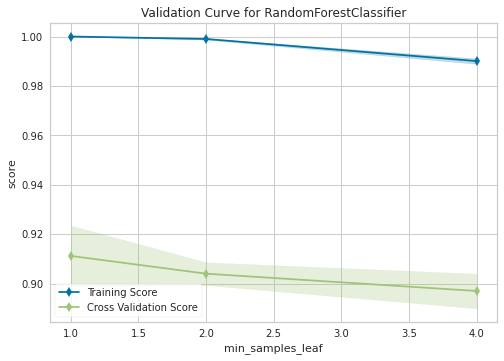

In [61]:
viz = ValidationCurve(rf, param_name="min_samples_leaf",
    param_range=[1, 2, 4], cv=5, scoring="accuracy"
)

viz.fit(X_train_augmented[:5000],y_train_augmented[:5000]);
viz.show();

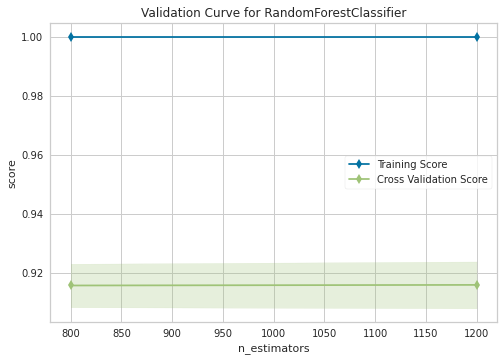

In [62]:
viz = ValidationCurve(rf, param_name="n_estimators",
    param_range=[800,1200], cv=5, scoring="accuracy"
)

viz.fit(X_train_augmented[:5000],y_train_augmented[:5000]);
viz.show();

In [63]:
grid_rf = RandomForestClassifier(n_estimators=800,max_depth=20,min_samples_split=2,min_samples_leaf=1,random_state=101)

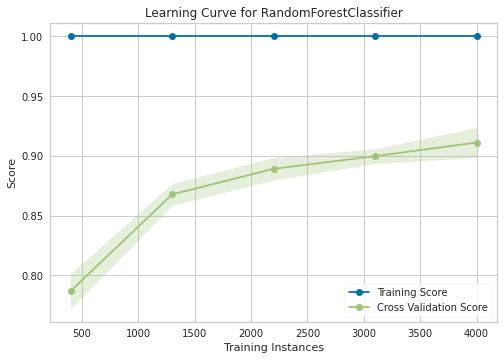

In [65]:
#Plotting learning curve to assess if the model is generalizing.
model = rf
visualizer = LearningCurve(
    model,  scoring='accuracy',  n_jobs=4
)

visualizer.fit(X_train_augmented[:5000], y_train_augmented[:5000])      
visualizer.show();

**Analysis**
> We can see the model is overfititng but as the training instances are increasing the test_score is increasing, it means we can reduce overfitting by adding more examples.

## Final Evaluation

In [76]:
#Evaluation on original dataset
rf.fit(X_train,y_train)
base_score=rf.score(X_val,y_val)

In [77]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)

In [78]:
#Evaluation on scalled original dataset
rf.fit(scaled_X_train,y_train)
scaled_base_score = rf.score(scaled_X_val,y_val)

In [69]:
scaled_X_train_aug = scaler.fit_transform(X_train_augmented)
scaled_X_val  =scaler.transform(X_val.values) #<-- .values is used to make X_val in same format as X_train_augmented is 

In [70]:
#Evaluation on scaled augmented dataset
rf.fit(scaled_X_train_aug,y_train_augmented)
aug_scaled_score=rf.score(scaled_X_val,y_val)

In [71]:
#Evaluation on scaled augmented dataset with tuned RandomForestClassifier
grid_rf.fit(scaled_X_train_aug,y_train_augmented)
tuned_scaled_aug_score=grid_rf.score(scaled_X_val,y_val)

In [88]:
Final_results  = pd.DataFrame({"base_score":base_score,"scaled_base_score":scaled_base_score,
                               "aug_scaled_score":aug_scaled_score,"tuned_scaled_aug_score":tuned_scaled_aug_score}, index=[0])
Final_results

,base_score,scaled_base_score,aug_scaled_score,tuned_scaled_aug_score
0,0.964286,0.964286,0.97631,0.975714


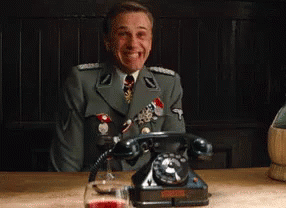

In [97]:
#Increment in score with data augmentation and scaling is 1.18 percent.
print(f'The increment in score after doing data augmentation is {((tuned_scaled_aug_score-base_score)/base_score)*100:.2f} %')

The increment in score after doing data augmentation is 1.19 %


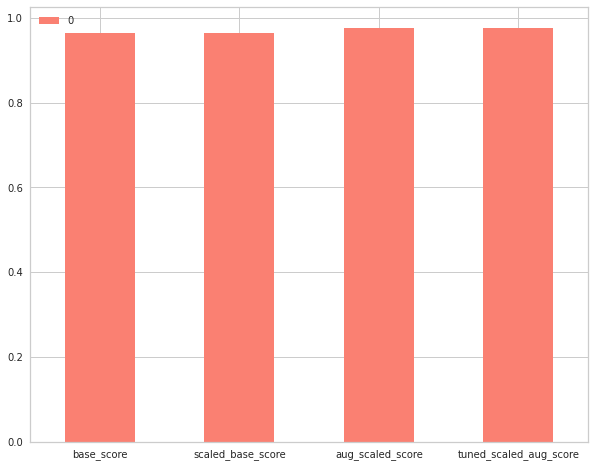

In [92]:
Final_results.T.plot.bar(figsize=(10,8),color='salmon')
plt.xticks(rotation=0);

Finally, it seems like model without tuned is giving best scores among all models.
The best part is we got almost 1.2 % increment in scores.

In [46]:
#Saving the best model
pickle.dump(rf, open("rf_model_1.pkl", "wb"))

In [107]:
scaled_X_train_aug= scaler.fit_transform(X_train_augmented)
scaled_test_data= scaler.transform(test_data.values)

In [108]:
#Creating submission file
rf.fit(scaled_X_train_aug,y_train_augmented)
final_predictions = rf.predict(scaled_test_data)

In [109]:
submission = pd.DataFrame({"ImageId":np.arange(1,len(test_data)+1),"Label":final_predictions})
submission.to_csv('submission_mnist_8.csv', index=False)

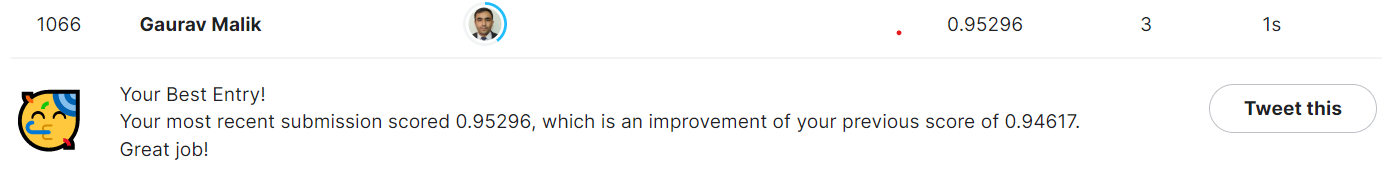

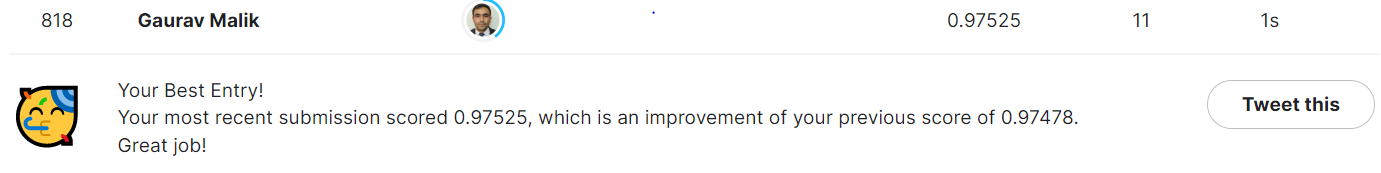

**As we can see in above screenshots, accuracy scores increased from 0.94 to 0.975 after data augmentation and scalling of data on Leader board.**